# Part 6: Catboost 

### Objective

**Fit Model:** We will forecast the price of municipal green bonds on the "covid", "post_covid", and "full" dataset using *Catboost*. To select the hyperparameters for our model, we will do time series cross validation on the training set. When doing this time series cross validation, we will when possible test the default hyperparameters against new hyperparameters. Sometimes, documentation on the tree model is not complete, and the exact default hyperparameter is not confidently known. 

**Evaluate Forecast:** Once we have trained our model on the 80% of training data, we will test it against the 20% of testing data. We will plot the results of our forecasts for the "covid", "post covid", and "full" data sets. We will display the mean squared error (MSE), $r^2$, root mean squared error (RMSE), mean absolute error (MAE), and mean absolute percentage error (MAPE) of our forecats. 

**Explain Forecast:** Finally, we will use the "shap" package in python to plot various SHAP graphs, which will give us an explanation behind the drivers of our forecasted values over the testing set. 

In [1]:
from catboost import CatBoostRegressor
import pandas as pd
import numpy as np
import shap

import my_functions

shap.initjs()

## Default Parameters

- Iterations: 1000. Iterations is a new name for what is referred to as "n_estimators" in the other tree models
- max_depth: 6
- learning rate: automatically detected by catboost "based on dataset properties and number of iterations" Generally seems to be around 0.3.

## Import Data

In [2]:
# import all data
df_covid = pd.read_excel("./cleaned_excel_data/covid_data.xlsx")
df_post_covid = pd.read_excel("./cleaned_excel_data/post_covid_data.xlsx")
df_full = pd.read_excel("./cleaned_excel_data/full_data.xlsx")

In [3]:
# covid data
X_covid = df_covid.drop(columns=['date', 'mgb_log_diff'])
y_covid = df_covid['mgb_log_diff']
# train test split
split_idx = int(0.8 * len(df_covid))
X_train_covid, X_test_covid = X_covid[:split_idx], X_covid[split_idx:]
y_train_covid, y_test_covid = y_covid[:split_idx], y_covid[split_idx:]


# post covid data
X_post_covid = df_post_covid.drop(columns=['date', 'mgb_log_diff'])
y_post_covid = df_post_covid['mgb_log_diff']
# train test split
split_idx = int(0.8 * len(df_post_covid))
X_train_post_covid, X_test_post_covid = X_post_covid[:split_idx], X_post_covid[split_idx:]
y_train_post_covid, y_test_post_covid = y_post_covid[:split_idx], y_post_covid[split_idx:]

# full data
X_full = df_full.drop(columns=['date', 'mgb_log_diff'])
y_full = df_full['mgb_log_diff']
# train test split
split_idx = int(0.8 * len(df_full))
X_train_full, X_test_full = X_full[:split_idx], X_full[split_idx:]
y_train_full, y_test_full = y_full[:split_idx], y_full[split_idx:]

## Find Optimal Parameters (Time Series Cross Validation)

In [4]:
param_grid = {
    'max_depth': [6,7,8],
    'iterations' : [250, 500, 1000],
    'learning_rate' : [0.01, 0.3], # I have tested 0.01 against 0.02 in the past. 0.01 is preferred. 
    'thread_count' : [-1] # this is just to make the code run faster
}

# catboost runs exceedlingly slowly

#### Covid Time Period

In [5]:
best_params_covid, best_mse_covid = my_functions.time_series_cv_tuning_catboost(X_train_covid, y_train_covid, param_grid, print_results = False)


Testing parameters: {'max_depth': 6, 'iterations': 250, 'learning_rate': 0.01, 'thread_count': -1}
Avg MSE: 117.7653

Testing parameters: {'max_depth': 6, 'iterations': 250, 'learning_rate': 0.3, 'thread_count': -1}
Avg MSE: 192.8060

Testing parameters: {'max_depth': 6, 'iterations': 500, 'learning_rate': 0.01, 'thread_count': -1}
Avg MSE: 128.9946

Testing parameters: {'max_depth': 6, 'iterations': 500, 'learning_rate': 0.3, 'thread_count': -1}
Avg MSE: 192.8688

Testing parameters: {'max_depth': 6, 'iterations': 1000, 'learning_rate': 0.01, 'thread_count': -1}
Avg MSE: 148.9656

Testing parameters: {'max_depth': 6, 'iterations': 1000, 'learning_rate': 0.3, 'thread_count': -1}
Avg MSE: 192.8889

Testing parameters: {'max_depth': 7, 'iterations': 250, 'learning_rate': 0.01, 'thread_count': -1}
Avg MSE: 112.4988

Testing parameters: {'max_depth': 7, 'iterations': 250, 'learning_rate': 0.3, 'thread_count': -1}
Avg MSE: 145.2718

Testing parameters: {'max_depth': 7, 'iterations': 500, '

#### Post Covid Time Period

In [6]:
best_params_post_covid, best_mse_post_covid = (
    my_functions.time_series_cv_tuning_catboost(X_train_post_covid, y_train_post_covid, param_grid, print_results = False)
)


Testing parameters: {'max_depth': 6, 'iterations': 250, 'learning_rate': 0.01, 'thread_count': -1}
Avg MSE: 29.5500

Testing parameters: {'max_depth': 6, 'iterations': 250, 'learning_rate': 0.3, 'thread_count': -1}
Avg MSE: 30.6003

Testing parameters: {'max_depth': 6, 'iterations': 500, 'learning_rate': 0.01, 'thread_count': -1}
Avg MSE: 27.8145

Testing parameters: {'max_depth': 6, 'iterations': 500, 'learning_rate': 0.3, 'thread_count': -1}
Avg MSE: 30.6009

Testing parameters: {'max_depth': 6, 'iterations': 1000, 'learning_rate': 0.01, 'thread_count': -1}
Avg MSE: 27.8985

Testing parameters: {'max_depth': 6, 'iterations': 1000, 'learning_rate': 0.3, 'thread_count': -1}
Avg MSE: 30.6009

Testing parameters: {'max_depth': 7, 'iterations': 250, 'learning_rate': 0.01, 'thread_count': -1}
Avg MSE: 30.2666

Testing parameters: {'max_depth': 7, 'iterations': 250, 'learning_rate': 0.3, 'thread_count': -1}
Avg MSE: 31.1697

Testing parameters: {'max_depth': 7, 'iterations': 500, 'learning

#### Full Time Period

In [7]:
best_params_full, best_mse_full = my_functions.time_series_cv_tuning_catboost(X_train_full, y_train_full, param_grid, print_results = False)


Testing parameters: {'max_depth': 6, 'iterations': 250, 'learning_rate': 0.01, 'thread_count': -1}
Avg MSE: 100.4937

Testing parameters: {'max_depth': 6, 'iterations': 250, 'learning_rate': 0.3, 'thread_count': -1}
Avg MSE: 151.3818

Testing parameters: {'max_depth': 6, 'iterations': 500, 'learning_rate': 0.01, 'thread_count': -1}
Avg MSE: 104.7447

Testing parameters: {'max_depth': 6, 'iterations': 500, 'learning_rate': 0.3, 'thread_count': -1}
Avg MSE: 151.4636

Testing parameters: {'max_depth': 6, 'iterations': 1000, 'learning_rate': 0.01, 'thread_count': -1}
Avg MSE: 116.3814

Testing parameters: {'max_depth': 6, 'iterations': 1000, 'learning_rate': 0.3, 'thread_count': -1}
Avg MSE: 151.4676

Testing parameters: {'max_depth': 7, 'iterations': 250, 'learning_rate': 0.01, 'thread_count': -1}
Avg MSE: 100.1177

Testing parameters: {'max_depth': 7, 'iterations': 250, 'learning_rate': 0.3, 'thread_count': -1}
Avg MSE: 124.9533

Testing parameters: {'max_depth': 7, 'iterations': 500, '

## See Quality of Prediction 

We will use the optimal parameters to train the model

#### Covid Time Period

In [8]:
model_catboost_covid =  CatBoostRegressor(verbose = 0, **best_params_covid)
model_catboost_covid.fit(X_train_covid, y_train_covid)

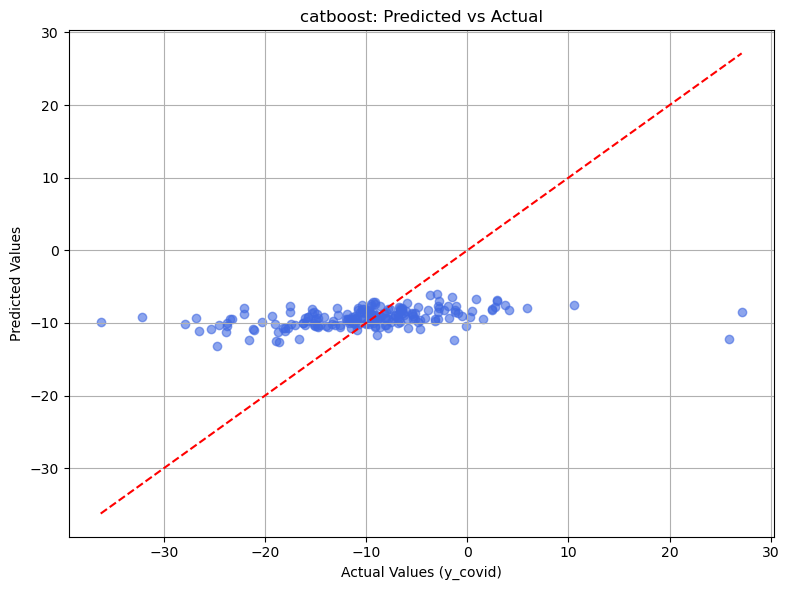

MSE of catboost: 58.3780
R² of catboost: 0.0952
RMSE of catboost: 7.6405
MAE of catboost: 5.3026
MAPE of catboost: 1.60%


In [9]:
metrics = my_functions.evaluate_model_performance(model_catboost_covid, X_test_covid, y_test_covid, 
                                   model_name="catboost", target_name="y_covid")

#### Post Covid Time Period

In [10]:
model_catboost_post_covid = CatBoostRegressor(verbose = 0 ,**best_params_post_covid)
model_catboost_post_covid.fit(X_train_post_covid, y_train_post_covid)

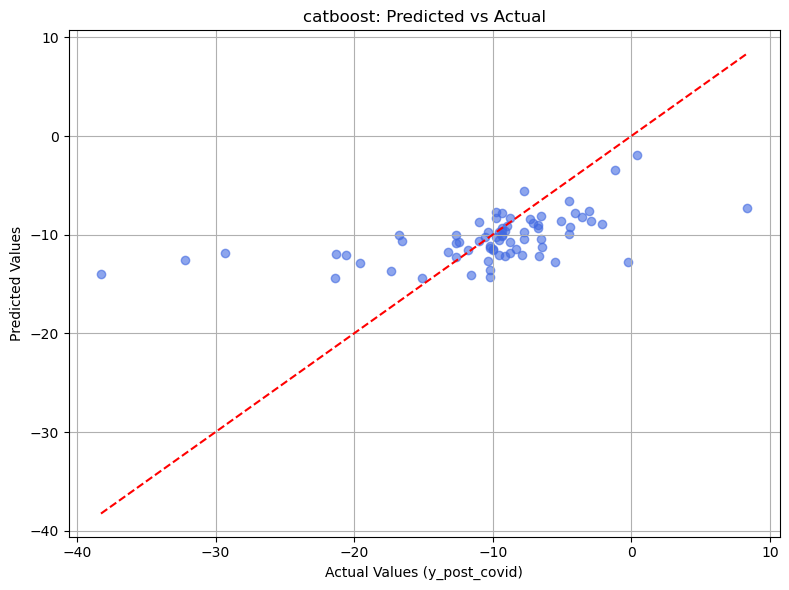

MSE of catboost: 34.7511
R² of catboost: 0.2650
RMSE of catboost: 5.8950
MAE of catboost: 3.8072
MAPE of catboost: 1.15%


In [11]:
metrics = my_functions.evaluate_model_performance(model_catboost_post_covid, X_test_post_covid, y_test_post_covid, 
                                   model_name="catboost", target_name="y_post_covid")

#### Full Time Period

In [12]:
model_catboost_full = CatBoostRegressor(verbose = 0 ,**best_params_full)
model_catboost_full.fit(X_train_full, y_train_full)

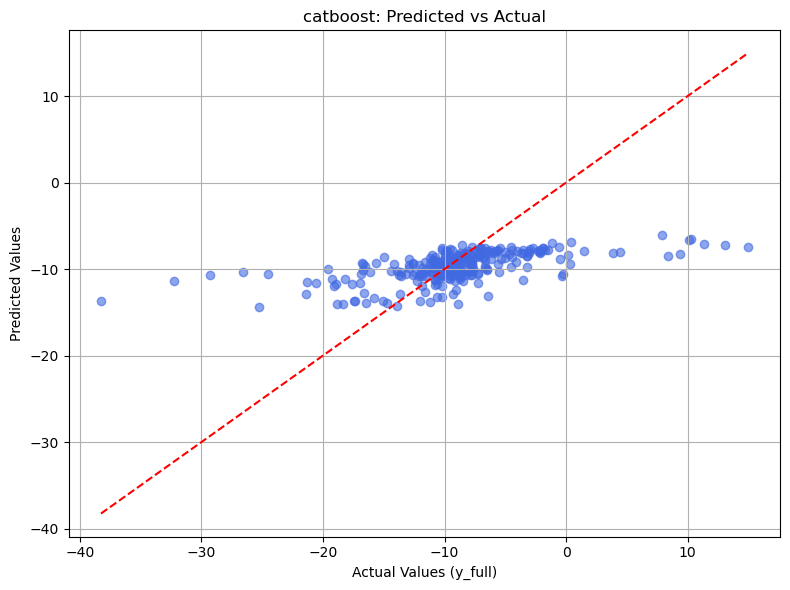

MSE of catboost: 29.5709
R² of catboost: 0.2407
RMSE of catboost: 5.4379
MAE of catboost: 3.4703
MAPE of catboost: 1.24%


In [13]:
metrics = my_functions.evaluate_model_performance(model_catboost_full, X_test_full, y_test_full, 
                                   model_name="catboost", target_name="y_full")

## SHAP Plots

We will fit SHAP plots onto the test set.

#### Covid Time Period

1. Beeswarm plot


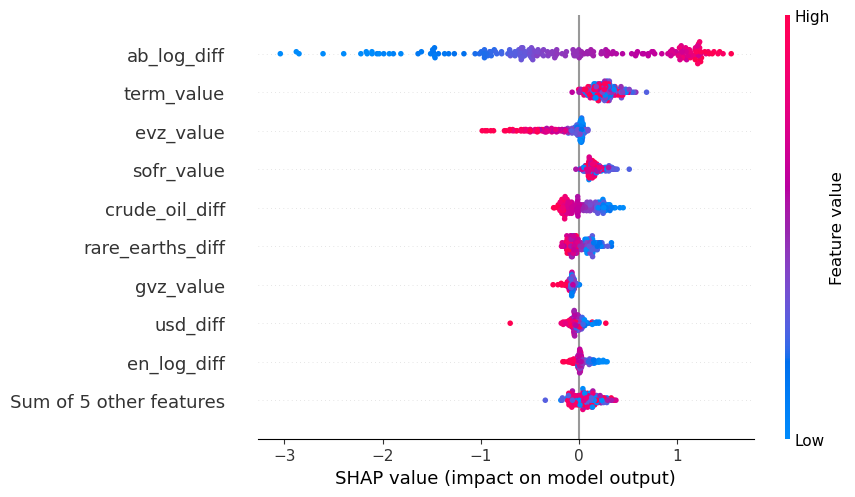

2. Feature importance bar plot


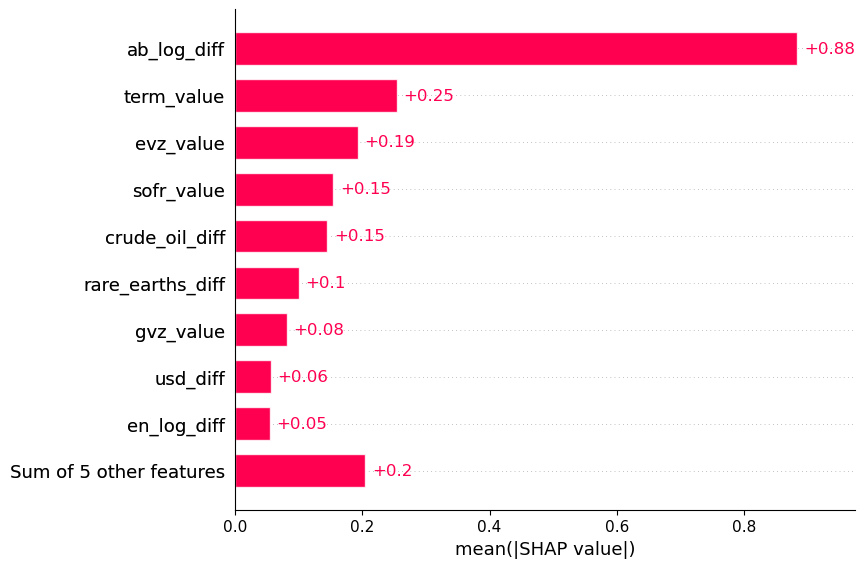

3. Dependence plots grid


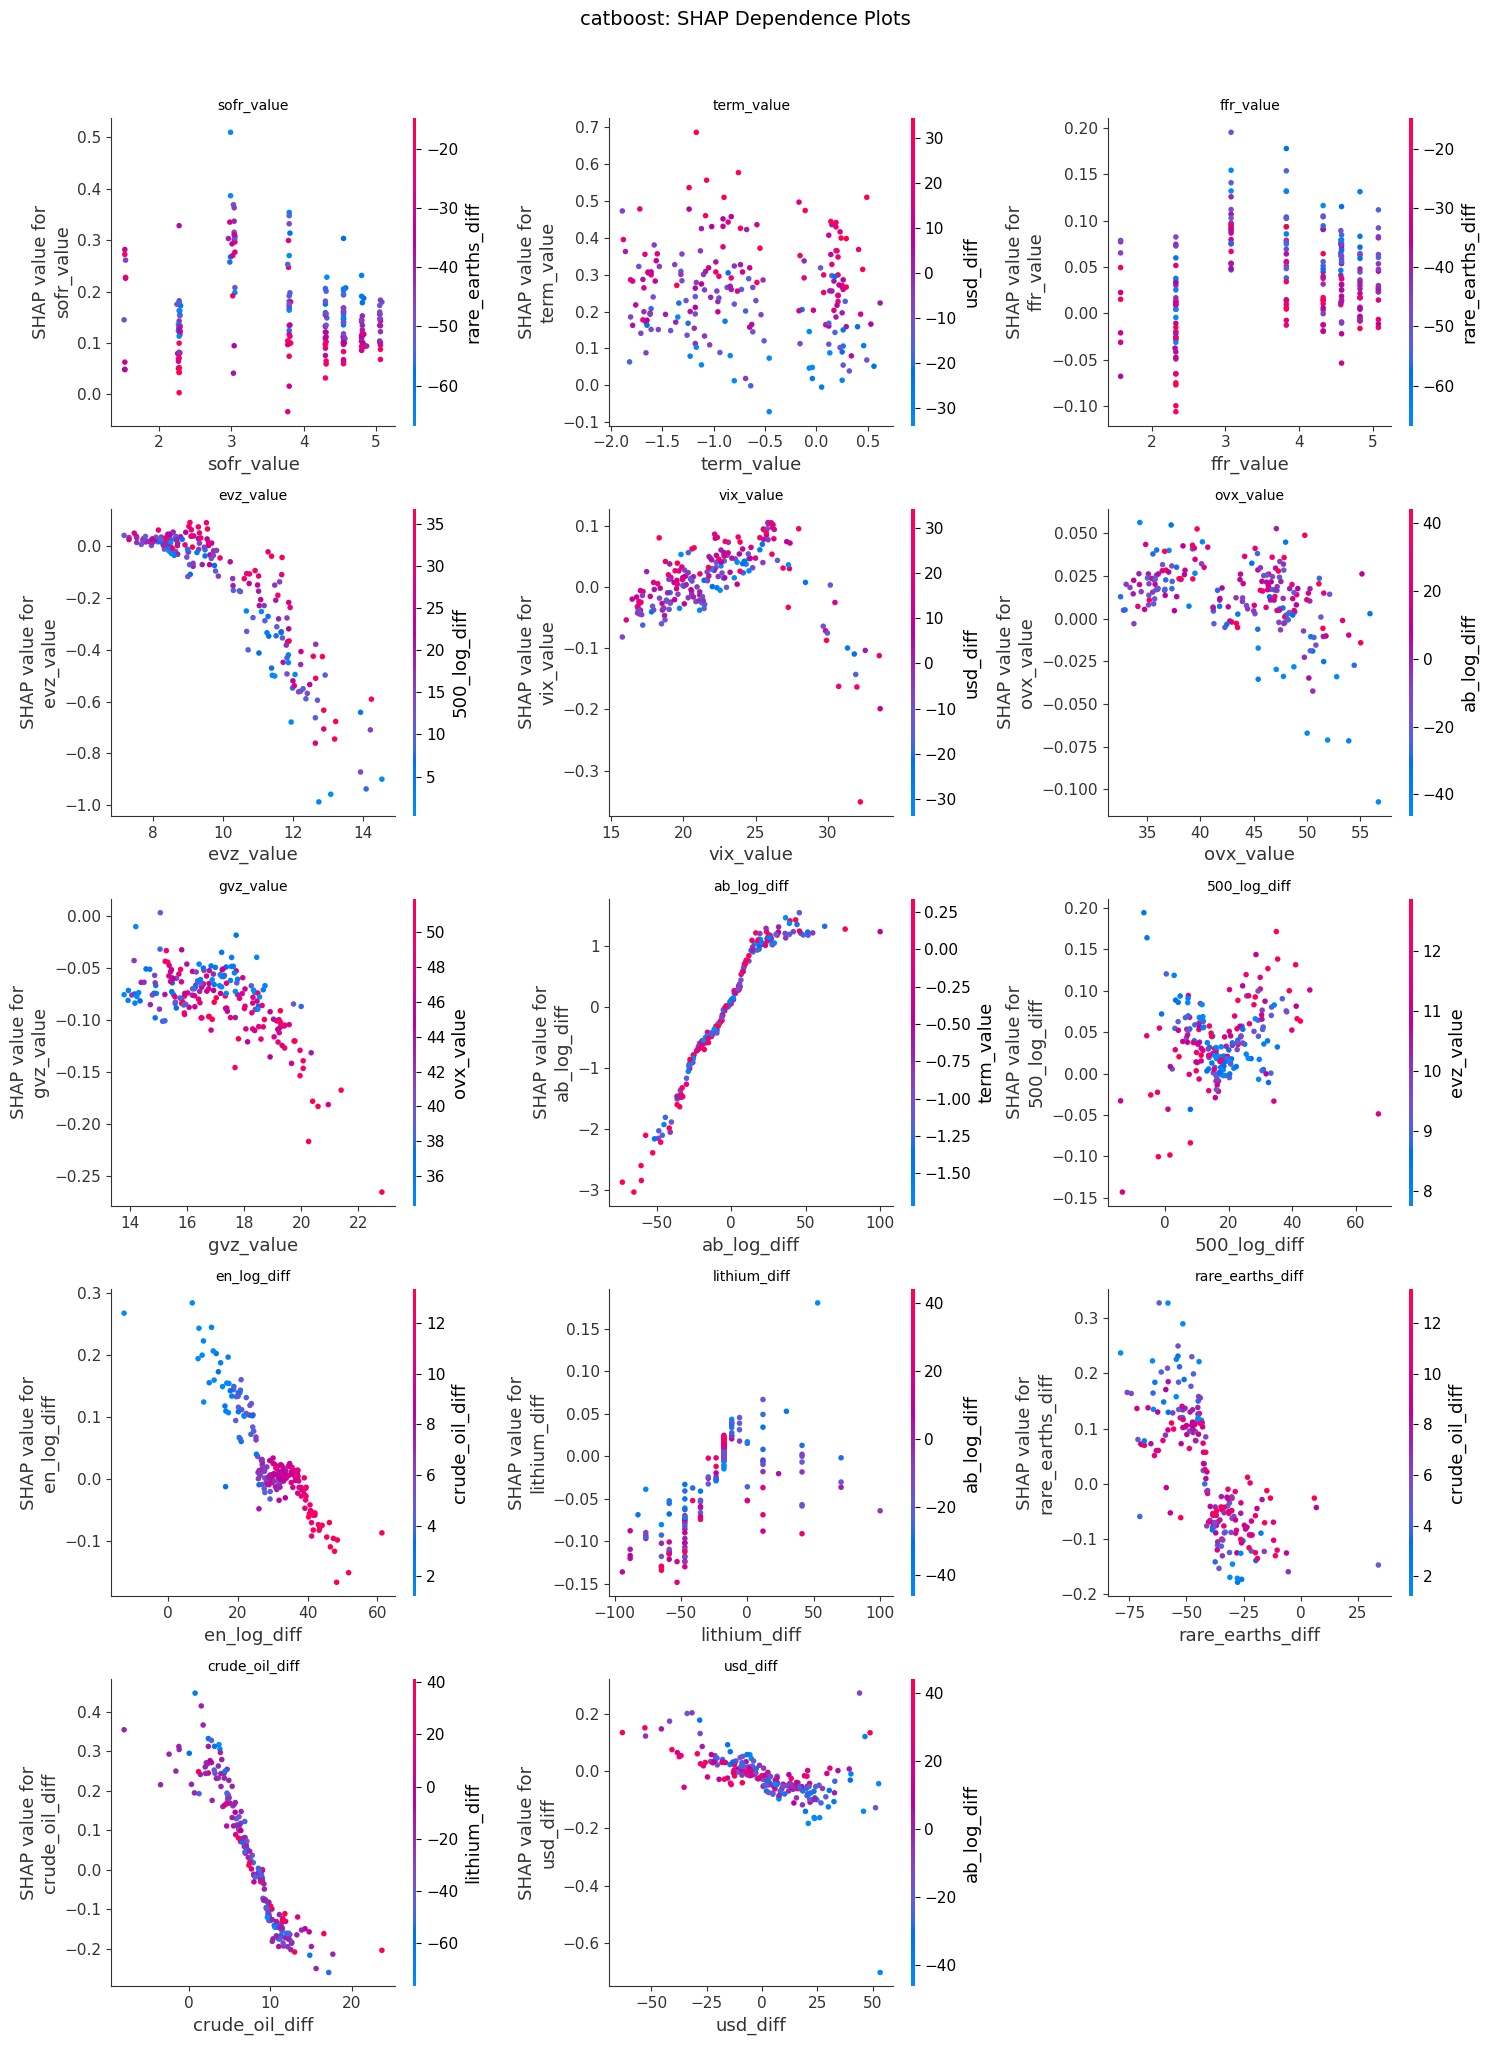

4. Heatmap ordered by predictions


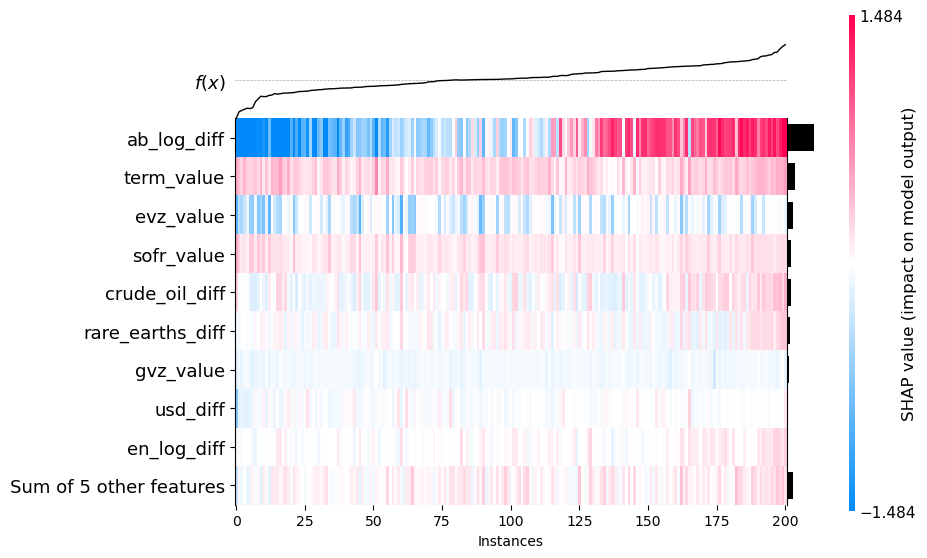

In [14]:
shap_covid = my_functions.shap_analysis_complete(model_catboost_covid, X_train_covid, X_test_covid, 
                                model_name="catboost", n_cols=3)

#### Post Covid Time Period

1. Beeswarm plot


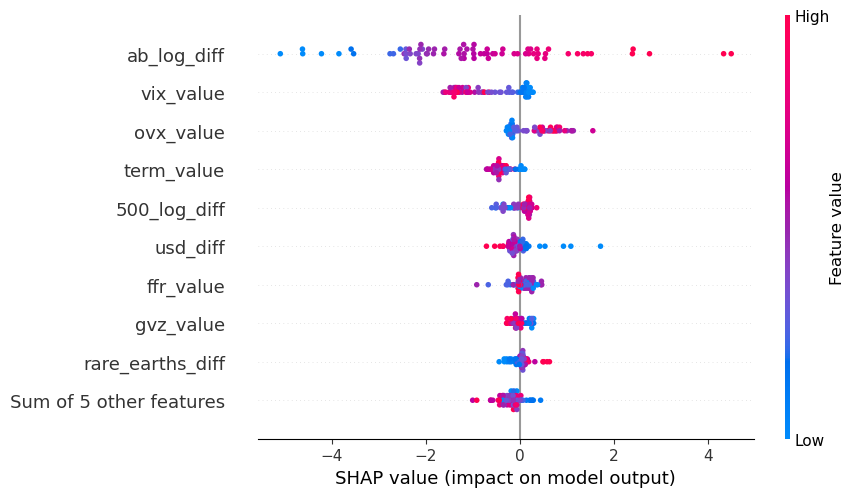

2. Feature importance bar plot


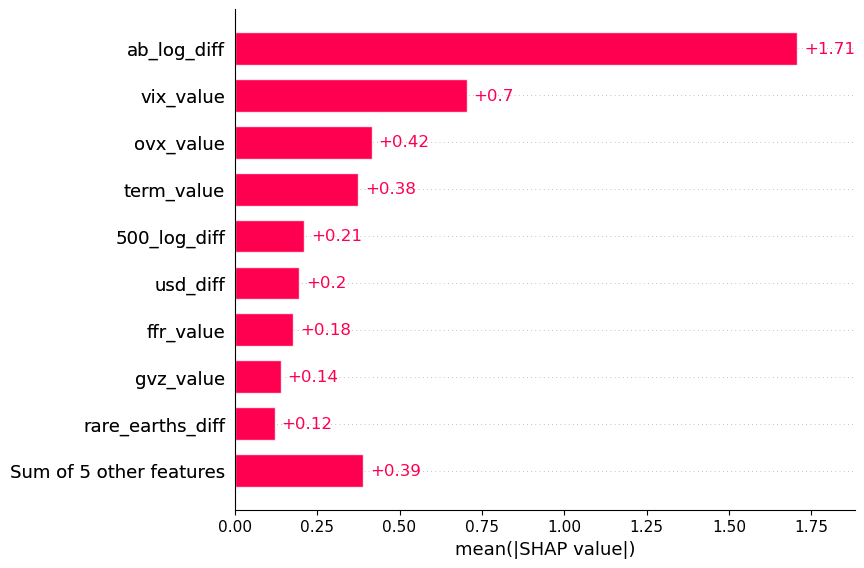

3. Dependence plots grid


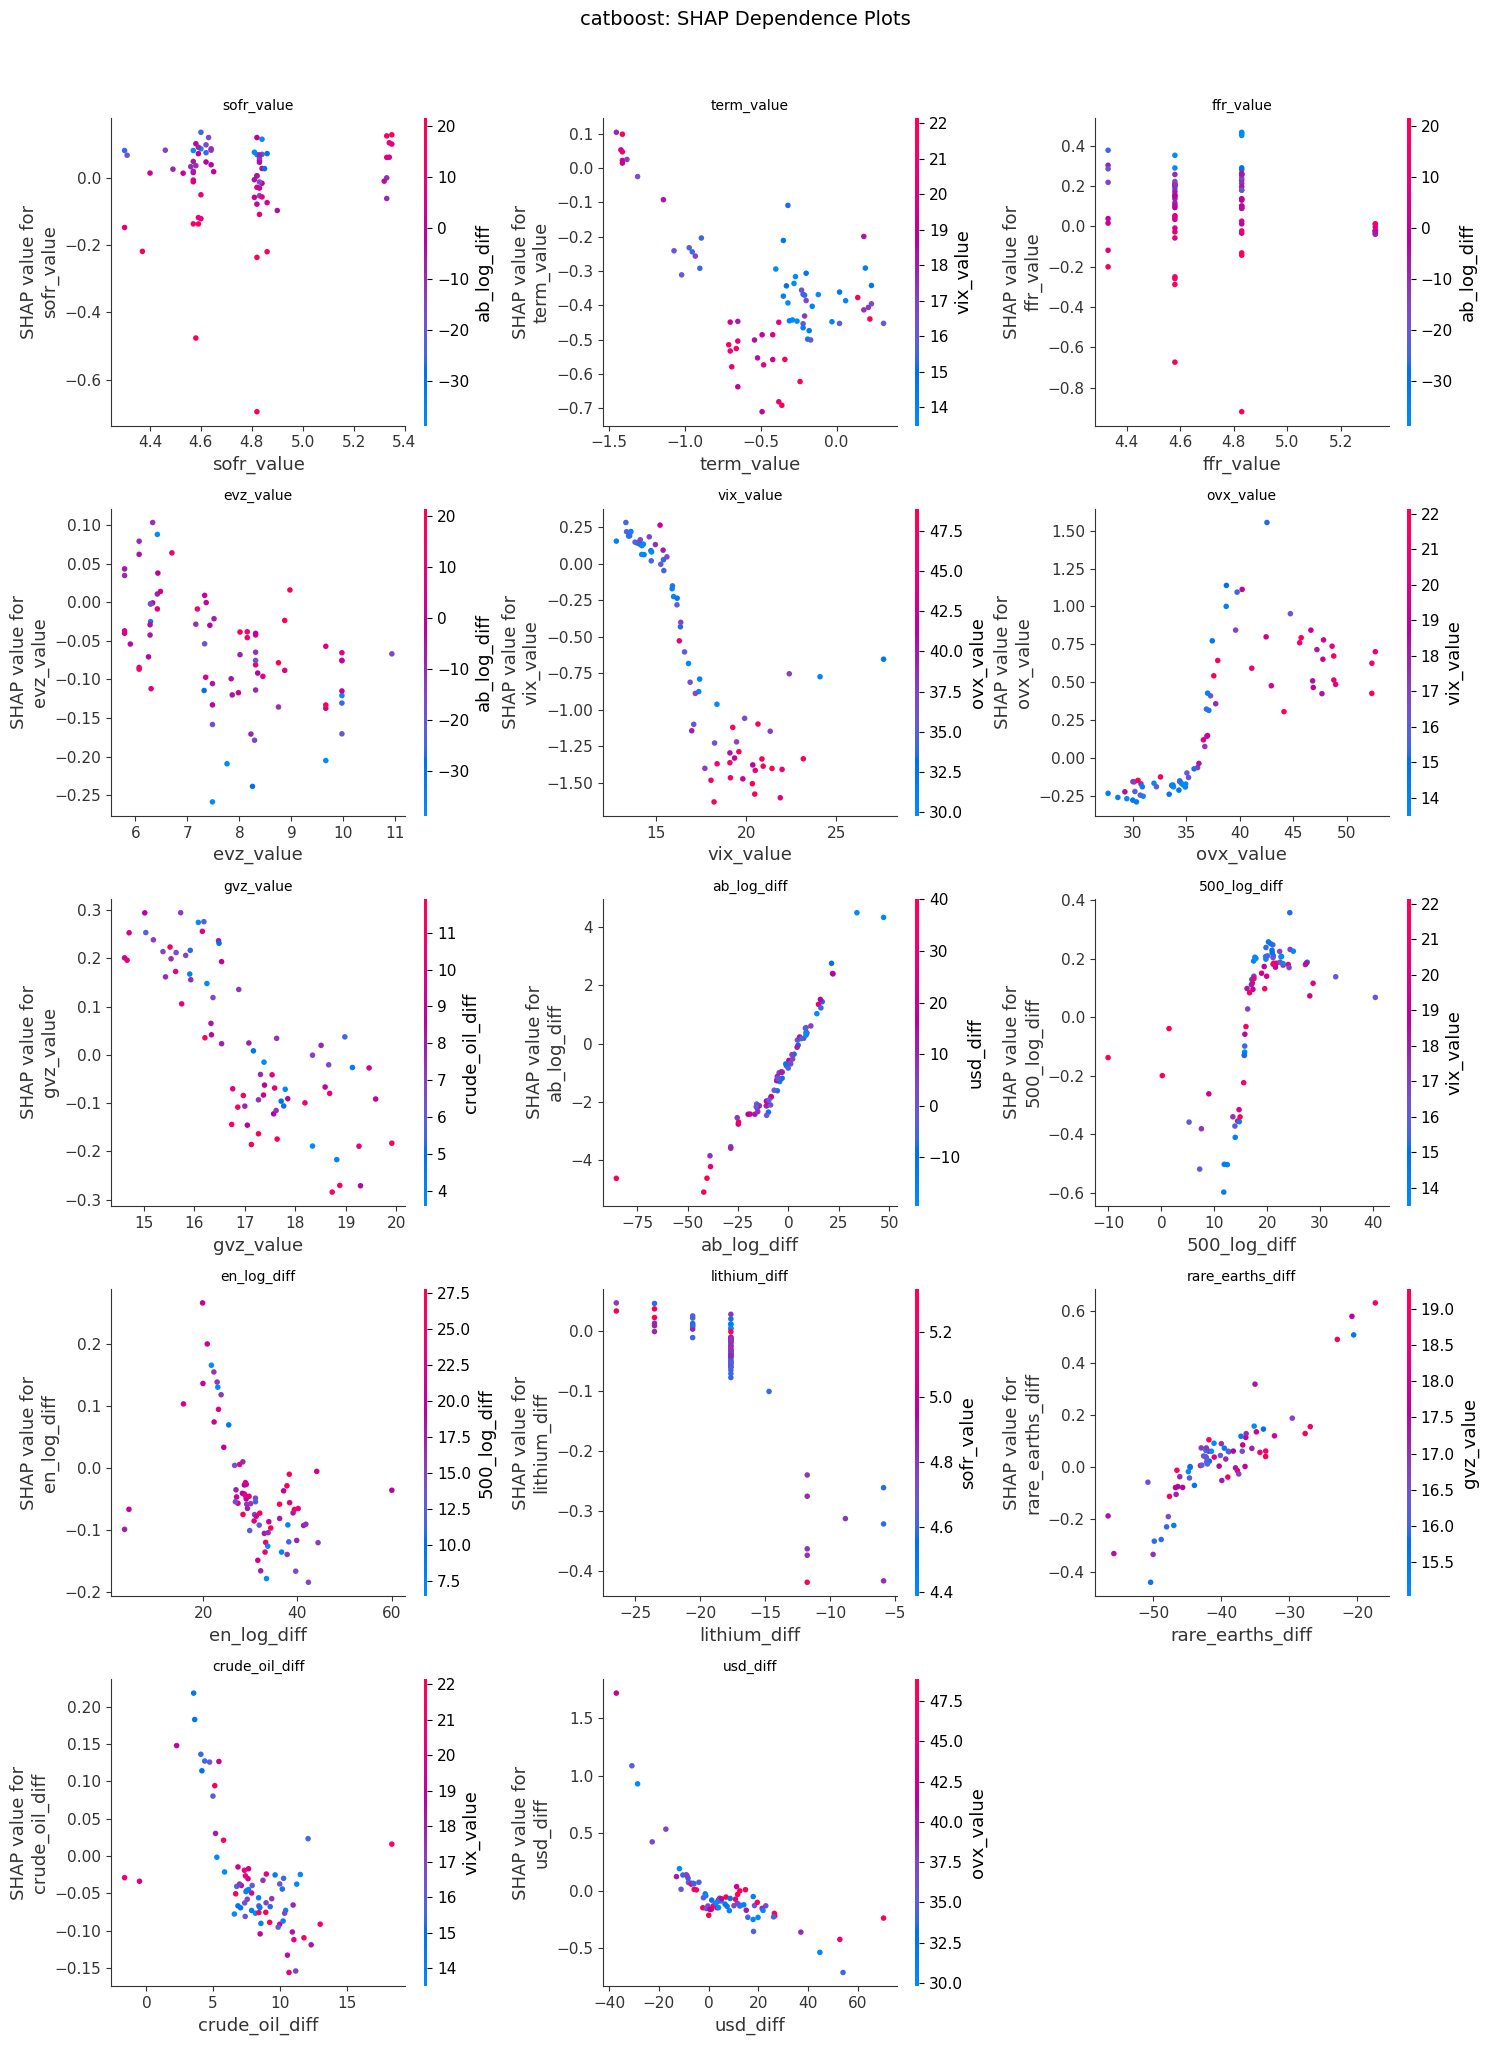

4. Heatmap ordered by predictions


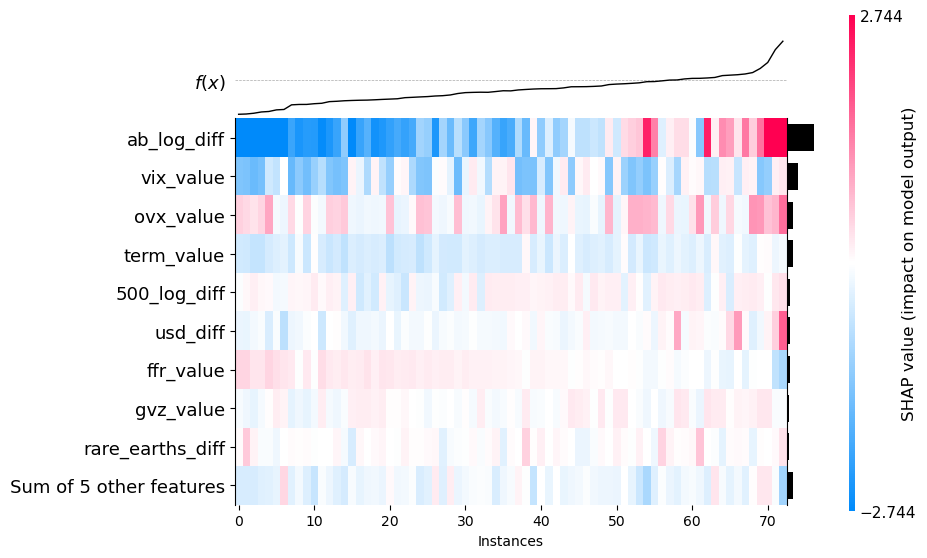

In [15]:
shap_post_covid = my_functions.shap_analysis_complete(model_catboost_post_covid, X_train_post_covid, X_test_post_covid, 
                                model_name="catboost", n_cols=3)

#### Full Time Period

1. Beeswarm plot


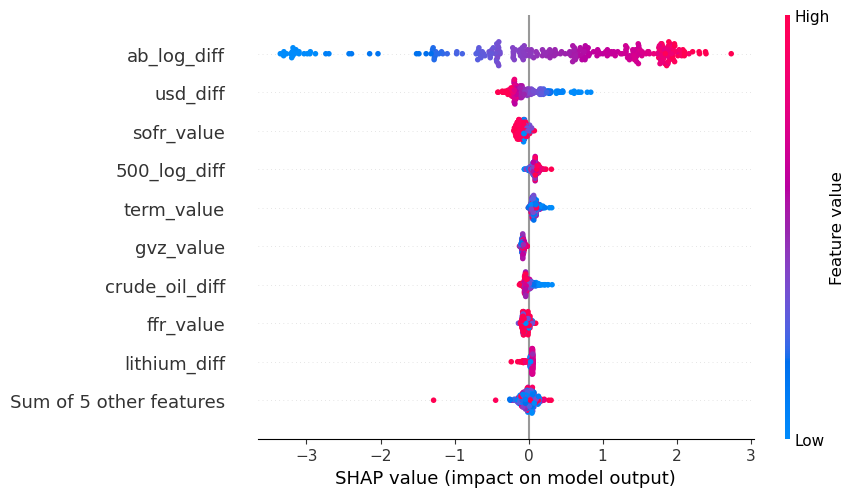

2. Feature importance bar plot


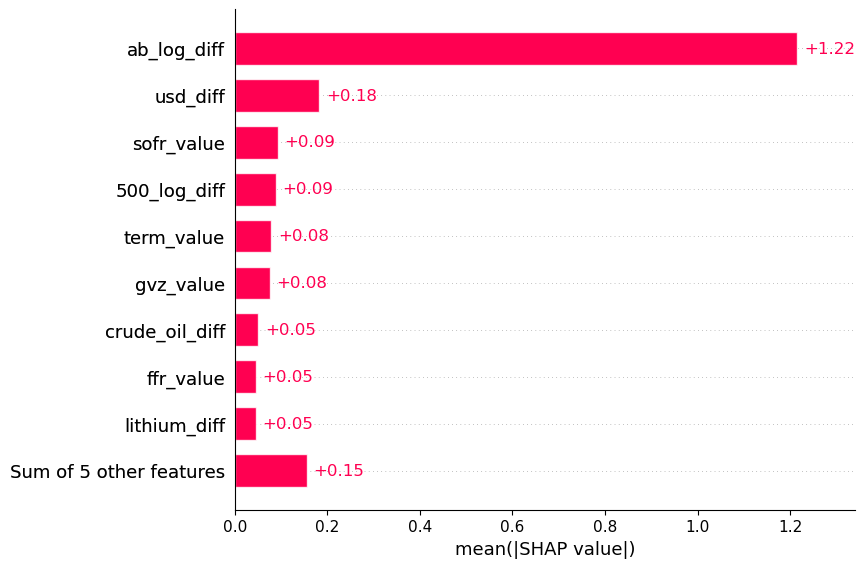

3. Dependence plots grid


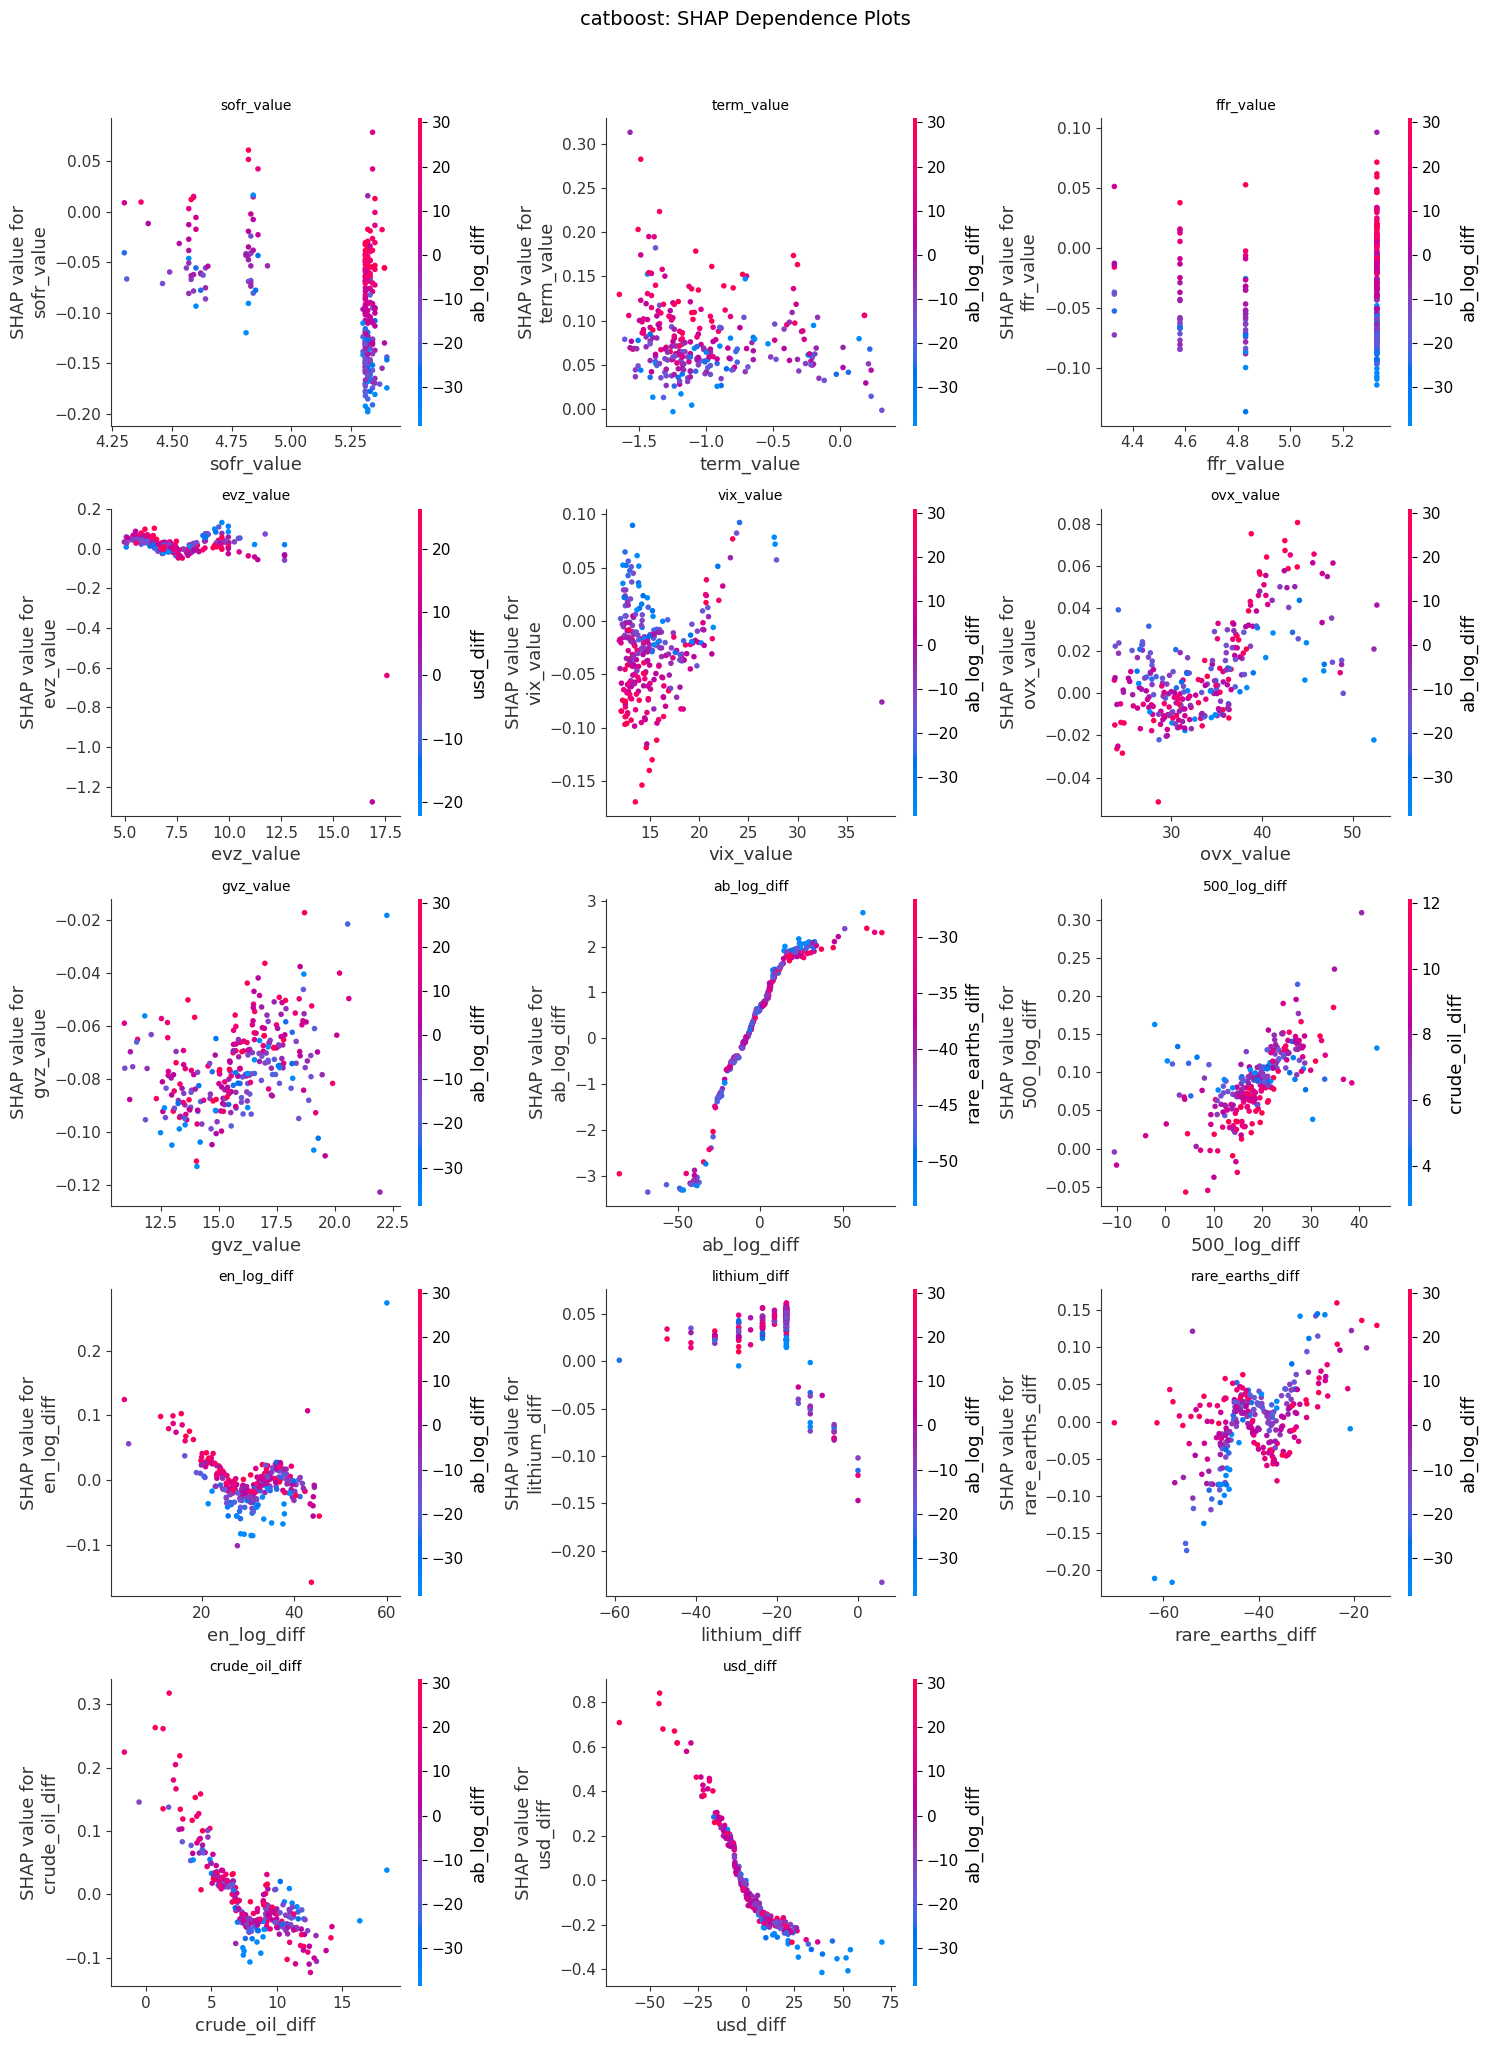

4. Heatmap ordered by predictions


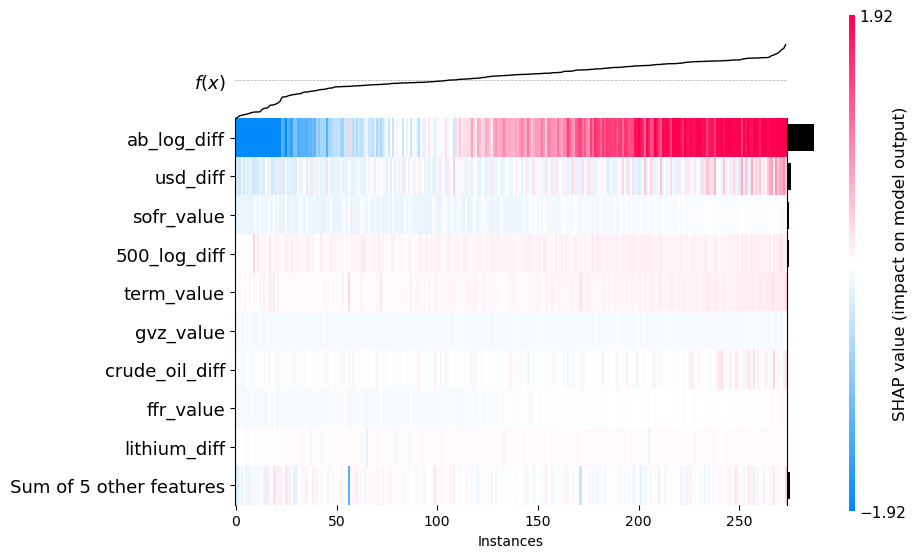

In [16]:
shap_full = my_functions.shap_analysis_complete(model_catboost_full, X_train_full, X_test_full, 
                                model_name="catboost", n_cols=3)